In [1]:
import os
import cv2
import inspect # 패키지와 모듈의 위치를 찾아줌
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.applications as applications
from keras import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer # 코드의 실행 시간 측정
from tqdm import tqdm # 작업진행률 표시

# load data

In [2]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/Dataset/With Mask/1572.png
/content/drive/MyDrive/Dataset/With Mask/1406.png
/content/drive/MyDrive/Dataset/With Mask/Augmented_110_8567370.png
/content/drive/MyDrive/Dataset/With Mask/155.png
/content/drive/MyDrive/Dataset/With Mask/Augmented_106_6675239.png
/content/drive/MyDrive/Dataset/With Mask/1374.png
/content/drive/MyDrive/Dataset/With Mask/226.png
/content/drive/MyDrive/Dataset/With Mask/Augmented_109_7984988.png
/content/drive/MyDrive/Dataset/With Mask/237.png
/content/drive/MyDrive/Dataset/With Mask/Augmented_100_9435902.png
/content/drive/MyDrive/Dataset/With Mask/627.png
/content/drive/MyDrive/Dataset/With Mask/50.png
/content/drive/MyDrive/Dataset/With Mask/1364.png
/content/drive/MyDrive/Dataset/With Mask/425.png
/content/drive/MyDrive/Dataset/With Mask/1003.png
/content/drive/MyDrive/Dataset/With Mask/579.png
/content/drive/MyDrive/Dataset/With Mask/1416.png
/content/drive/MyDrive/Dataset/With Mask/394.png
/cont

In [3]:
path = '/content/drive/MyDrive/Dataset/'

In [4]:
# 마스크 미착용된 사진들의 디렉터리 모음
without_mask_dir = [path+'Without Mask']

# 마스크 착용된 사진들의 디렉터리 모음
with_mask_dir = [path+'With Mask']

# 마스크를 제대로 착용하지 않은 사진들의 디렉터리 모음
invalid_mask_dir = [path+'Invalid Mask']

In [5]:
def folder_to_df(dirs, labels):
  file_list = []
  num_folders = len(dirs)
  for count, folder in enumerate(dirs, start=1):
    for file in sorted(os.listdir(folder)):
      if count == 1:
        file_list.append((folder+'/'+file, labels[0]))
      elif count == 2:
        file_list.append((folder+'/'+file, labels[1]))
      else:
        file_list.append((folder+'/'+file, labels[2]))
  return pd.DataFrame(file_list, columns=['filename', 'class'])

In [6]:
labels = ['Without Mask', 'With Mask', 'Invalid Mask']

all_mask_df = folder_to_df(without_mask_dir + with_mask_dir + invalid_mask_dir, labels)
shuffled_mask_df = all_mask_df.sample(frac=1)
shuffled_mask_df = shuffled_mask_df[:5000]
train_df, val_df, test_df = np.split(shuffled_mask_df, [int(0.8*len(shuffled_mask_df)),
                                                        int(0.9*len(shuffled_mask_df))])

In [7]:
# np.split(array, [2, 5])라고 한다면
# array[0:2], array[2:5], array[5:]에 해당하는 array 생성

In [8]:
print('total dataset : {} \ntraining set  : {} \nvalidation set: {} \ntest set      : {}'.\
      format(all_mask_df.shape, train_df.shape, val_df.shape, test_df.shape))
display(train_df.head(10), val_df.head(10), test_df.head(10))

total dataset : (18169, 2) 
training set  : (4000, 2) 
validation set: (500, 2) 
test set      : (500, 2)


,filename,class
16321,/content/drive/MyDrive/Dataset/Invalid Mask/04...,Invalid Mask
15416,/content/drive/MyDrive/Dataset/Invalid Mask/03...,Invalid Mask
8482,/content/drive/MyDrive/Dataset/With Mask/768.png,With Mask
16962,/content/drive/MyDrive/Dataset/Invalid Mask/05...,Invalid Mask
7423,/content/drive/MyDrive/Dataset/With Mask/06976...,With Mask
10093,/content/drive/MyDrive/Dataset/With Mask/Augme...,With Mask
3648,/content/drive/MyDrive/Dataset/Without Mask/43...,Without Mask
5507,/content/drive/MyDrive/Dataset/Without Mask/65...,Without Mask
4691,/content/drive/MyDrive/Dataset/Without Mask/53...,Without Mask
14637,/content/drive/MyDrive/Dataset/Invalid Mask/02...,Invalid Mask


,filename,class
1380,/content/drive/MyDrive/Dataset/Without Mask/23...,Without Mask
9797,/content/drive/MyDrive/Dataset/With Mask/Augme...,With Mask
10025,/content/drive/MyDrive/Dataset/With Mask/Augme...,With Mask
16823,/content/drive/MyDrive/Dataset/Invalid Mask/04...,Invalid Mask
6177,/content/drive/MyDrive/Dataset/With Mask/00131...,With Mask
2199,/content/drive/MyDrive/Dataset/Without Mask/30...,Without Mask
16255,/content/drive/MyDrive/Dataset/Invalid Mask/04...,Invalid Mask
7123,/content/drive/MyDrive/Dataset/With Mask/06671...,With Mask
436,/content/drive/MyDrive/Dataset/Without Mask/14...,Without Mask
12998,/content/drive/MyDrive/Dataset/Invalid Mask/00...,Invalid Mask


,filename,class
13197,/content/drive/MyDrive/Dataset/Invalid Mask/01...,Invalid Mask
6310,/content/drive/MyDrive/Dataset/With Mask/00917...,With Mask
12751,/content/drive/MyDrive/Dataset/Invalid Mask/00...,Invalid Mask
6056,/content/drive/MyDrive/Dataset/With Mask/00003...,With Mask
766,/content/drive/MyDrive/Dataset/Without Mask/17...,Without Mask
9099,/content/drive/MyDrive/Dataset/With Mask/Augme...,With Mask
10,/content/drive/MyDrive/Dataset/Without Mask/10...,Without Mask
9497,/content/drive/MyDrive/Dataset/With Mask/Augme...,With Mask
6281,/content/drive/MyDrive/Dataset/With Mask/00886...,With Mask
16732,/content/drive/MyDrive/Dataset/Invalid Mask/04...,Invalid Mask


# data augmentation

In [9]:
train_datagen = ImageDataGenerator(rotation_range=10,    # 기울어진 얼굴
                                   zoom_range=0.1,       # 확대된 얼굴
                                   horizontal_flip=True, # 좌우 반전된 얼굴
                                   rescale=1.0/255)      # 255개의 RGB values에 맞춰서 축소

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

In [10]:
VAL_BATCH_SIZE = 128
BATCH_SIZE = VAL_BATCH_SIZE * 8

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=BATCH_SIZE)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=VAL_BATCH_SIZE)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=VAL_BATCH_SIZE)

Found 4000 validated image filenames belonging to 3 classes.
Found 500 validated image filenames belonging to 3 classes.
Found 500 validated image filenames belonging to 3 classes.


In [11]:
def show_img_samples(dirs, num, label):
  folder = random.choice(dirs) # randomly choose folder
  images = random.sample(os.listdir(folder), num) # randomly choose img

  plt.figure(figsize=(20, 10))
  for i in range(num):
    plt.subplot(num // 5+1, 5, i+1)
    img = cv2.cvtColor(cv2.imread(folder+'/'+images[i]), cv2.COLOR_BGR2RGB)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel(label)
    plt.imshow(img)
  plt.show()

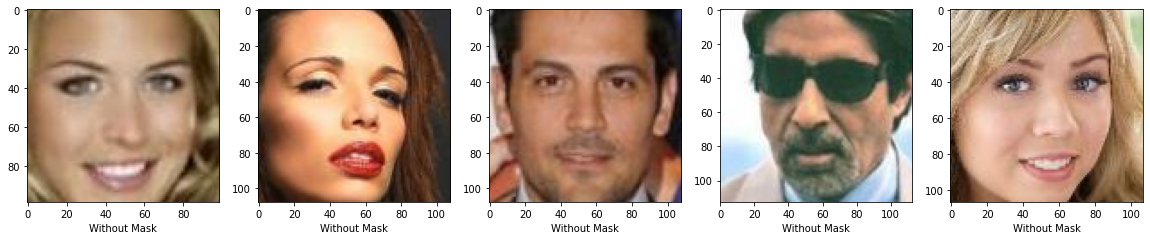

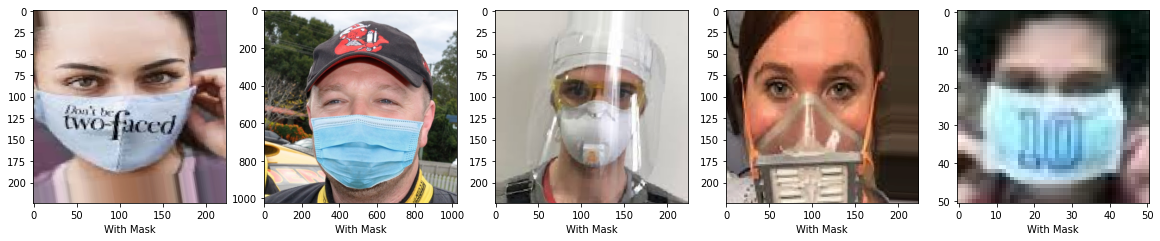

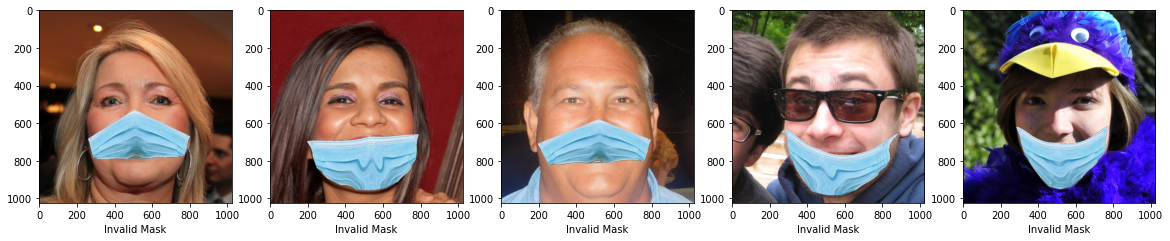

In [12]:
show_img_samples(without_mask_dir, 5, 'Without Mask')
show_img_samples(with_mask_dir, 5, 'With Mask')
show_img_samples(invalid_mask_dir, 5, 'Invalid Mask')

# transfer learning

In [13]:
class TimingCallback(Callback):
  def __init__(self, logs={}):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs={}):
    self.startime = timer()
  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(timer()-self.startime)

timing_callback = TimingCallback()

In [14]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(applications, inspect.isfunction)}
for key in model_dictionary:
  print(key)

model_benchmarks = {'model_name': [], 'num_model_params': [], 'val_loss': [], 'val_accuracy': [], 'avg_train_time': []}

for model_name, model in tqdm(model_dictionary.items()):
  if 'NASNetLarge' in model_name:
    input_shape=(331, 331, 3)
  elif 'NASNetMobile' in model_name:
    input_shape=(224, 224, 3)
  else:
    input_shape=(128, 128, 3)

  # base model 
  pre_trained_model = model(
      include_top=False,
      pooling='avg',
      input_shape=input_shape)
  pre_trained_model.trainable=False

  # transfer learning model 
  clf_model = Sequential([
      pre_trained_model,
      Flatten(),
      Dense(3, activation='softmax')])

  clf_model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  # training
  history = clf_model.fit(
      train_generator,
      epochs=3,
      callbacks=[timing_callback],
      validation_data=val_generator)  
  
  # logs
  model_benchmarks['model_name'].append(model_name)
  model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
  model_benchmarks['val_loss'].append(history.history['val_loss'][-1])
  model_benchmarks['val_accuracy'].append(history.history['val_accuracy'][-1])
  model_benchmarks['avg_train_time'].append(sum(timing_callback.logs)/3)

DenseNet121
DenseNet169
DenseNet201
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5
EfficientNetB6
EfficientNetB7
EfficientNetV2B0
EfficientNetV2B1
EfficientNetV2B2
EfficientNetV2B3
EfficientNetV2L
EfficientNetV2M
EfficientNetV2S
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
MobileNetV3Large
MobileNetV3Small
NASNetLarge
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
VGG16
VGG19
Xception


  0%|          | 0/35 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 873s 200s/step - loss: 0.9722 - accuracy: 0.5807 - val_loss: 0.8423 - val_accuracy: 0.6580
Epoch 2/3
4/4 [==============================] - 52s 13s/step - loss: 0.6918 - accuracy: 0.7138 - val_loss: 0.6257 - val_accuracy: 0.7340
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.5332 - accuracy: 0.7623 - val_loss: 0.4923 - val_accuracy: 0.7980


  3%|▎         | 1/35 [20:27<11:35:41, 1227.68s/it]

51888128/51877672 [==============================] - 4s 0us/step
Epoch 1/3
4/4 [==============================] - 61s 14s/step - loss: 1.0660 - accuracy: 0.4950 - val_loss: 0.7417 - val_accuracy: 0.6740
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 0.6164 - accuracy: 0.7430 - val_loss: 0.4511 - val_accuracy: 0.8380
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.3862 - accuracy: 0.8550 - val_loss: 0.2968 - val_accuracy: 0.8840


  6%|▌         | 2/35 [24:00<5:47:00, 630.93s/it]  

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 69s 15s/step - loss: 1.2785 - accuracy: 0.4708 - val_loss: 0.9935 - val_accuracy: 0.6560
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 0.8883 - accuracy: 0.6973 - val_loss: 0.6493 - val_accuracy: 0.7340
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.5543 - accuracy: 0.7670 - val_loss: 0.4887 - val_accuracy: 0.8000


  9%|▊         | 3/35 [27:40<3:56:16, 443.03s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 60s 14s/step - loss: 1.1014 - accuracy: 0.3355 - val_loss: 1.0978 - val_accuracy: 0.3360
Epoch 2/3
4/4 [==============================] - 49s 13s/step - loss: 1.1011 - accuracy: 0.3237 - val_loss: 1.0972 - val_accuracy: 0.4500
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.1023 - accuracy: 0.3338 - val_loss: 1.0973 - val_accuracy: 0.3360


 11%|█▏        | 4/35 [31:04<3:00:10, 348.72s/it]

27033600/27018416 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 61s 13s/step - loss: 1.1305 - accuracy: 0.3255 - val_loss: 1.1037 - val_accuracy: 0.3360
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.1176 - accuracy: 0.3280 - val_loss: 1.1058 - val_accuracy: 0.3360
Epoch 3/3
4/4 [==============================] - 49s 13s/step - loss: 1.1049 - accuracy: 0.3350 - val_loss: 1.1019 - val_accuracy: 0.3540


 14%|█▍        | 5/35 [34:01<2:23:19, 286.66s/it]

31801344/31790344 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 60s 13s/step - loss: 1.1163 - accuracy: 0.3395 - val_loss: 1.1162 - val_accuracy: 0.3360
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.1082 - accuracy: 0.3318 - val_loss: 1.1023 - val_accuracy: 0.3540
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.1054 - accuracy: 0.3402 - val_loss: 1.0975 - val_accuracy: 0.3540


 17%|█▋        | 6/35 [37:29<2:05:41, 260.06s/it]

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 64s 14s/step - loss: 1.1011 - accuracy: 0.3570 - val_loss: 1.0931 - val_accuracy: 0.4900
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 1.0960 - accuracy: 0.3520 - val_loss: 1.0937 - val_accuracy: 0.3180
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0956 - accuracy: 0.3537 - val_loss: 1.0895 - val_accuracy: 0.3540


 20%|██        | 7/35 [41:01<1:54:01, 244.33s/it]

71696384/71686520 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 66s 14s/step - loss: 1.1106 - accuracy: 0.3338 - val_loss: 1.1041 - val_accuracy: 0.3540
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.1035 - accuracy: 0.3282 - val_loss: 1.1034 - val_accuracy: 0.3360
Epoch 3/3
4/4 [==============================] - 51s 12s/step - loss: 1.1027 - accuracy: 0.3322 - val_loss: 1.0984 - val_accuracy: 0.3540


 23%|██▎       | 8/35 [44:35<1:45:38, 234.75s/it]

115277824/115263384 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 70s 14s/step - loss: 1.3122 - accuracy: 0.3397 - val_loss: 1.3200 - val_accuracy: 0.3100
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 1.2560 - accuracy: 0.3232 - val_loss: 1.1116 - val_accuracy: 0.3100
Epoch 3/3
4/4 [==============================] - 52s 13s/step - loss: 1.1403 - accuracy: 0.3332 - val_loss: 1.1823 - val_accuracy: 0.3360


 26%|██▌       | 9/35 [47:46<1:35:44, 220.93s/it]

165249024/165234480 [==============================] - 2s 0us/step
Epoch 1/3
4/4 [==============================] - 74s 15s/step - loss: 1.3105 - accuracy: 0.3313 - val_loss: 1.1814 - val_accuracy: 0.3100
Epoch 2/3
4/4 [==============================] - 54s 13s/step - loss: 1.1605 - accuracy: 0.3290 - val_loss: 1.1833 - val_accuracy: 0.3360
Epoch 3/3
4/4 [==============================] - 53s 13s/step - loss: 1.1367 - accuracy: 0.3390 - val_loss: 1.1396 - val_accuracy: 0.3100


 29%|██▊       | 10/35 [51:06<1:29:22, 214.52s/it]

258088960/258076736 [==============================] - 5s 0us/step
Epoch 1/3
4/4 [==============================] - 79s 16s/step - loss: 1.3310 - accuracy: 0.3330 - val_loss: 1.1190 - val_accuracy: 0.3360
Epoch 2/3
4/4 [==============================] - 54s 14s/step - loss: 1.1785 - accuracy: 0.3255 - val_loss: 1.2011 - val_accuracy: 0.3100
Epoch 3/3
4/4 [==============================] - 53s 13s/step - loss: 1.1472 - accuracy: 0.3158 - val_loss: 1.1862 - val_accuracy: 0.3360


 31%|███▏      | 11/35 [55:05<1:28:51, 222.15s/it]

24289280/24274472 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 58s 13s/step - loss: 1.1032 - accuracy: 0.3440 - val_loss: 1.0983 - val_accuracy: 0.3540
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.0994 - accuracy: 0.3270 - val_loss: 1.0997 - val_accuracy: 0.3100
Epoch 3/3
4/4 [==============================] - 49s 13s/step - loss: 1.0952 - accuracy: 0.3855 - val_loss: 1.0923 - val_accuracy: 0.4060


 34%|███▍      | 12/35 [57:57<1:19:17, 206.83s/it]

28467200/28456008 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 61s 14s/step - loss: 1.1011 - accuracy: 0.3460 - val_loss: 1.1084 - val_accuracy: 0.3540
Epoch 2/3
4/4 [==============================] - 49s 12s/step - loss: 1.1061 - accuracy: 0.3293 - val_loss: 1.1041 - val_accuracy: 0.3360
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.1035 - accuracy: 0.3350 - val_loss: 1.0960 - val_accuracy: 0.4140


 37%|███▋      | 13/35 [1:00:52<1:12:15, 197.05s/it]

35848192/35839040 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 61s 14s/step - loss: 1.0994 - accuracy: 0.3433 - val_loss: 1.1013 - val_accuracy: 0.3540
Epoch 2/3
4/4 [==============================] - 49s 12s/step - loss: 1.1036 - accuracy: 0.3500 - val_loss: 1.0920 - val_accuracy: 0.4480
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0986 - accuracy: 0.3370 - val_loss: 1.0990 - val_accuracy: 0.3100


 40%|████      | 14/35 [1:03:47<1:06:38, 190.38s/it]

52617216/52606240 [==============================] - 2s 0us/step
Epoch 1/3
4/4 [==============================] - 63s 14s/step - loss: 1.1038 - accuracy: 0.3402 - val_loss: 1.0993 - val_accuracy: 0.3540
Epoch 2/3
4/4 [==============================] - 49s 13s/step - loss: 1.1013 - accuracy: 0.3360 - val_loss: 1.0989 - val_accuracy: 0.3360
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0976 - accuracy: 0.3392 - val_loss: 1.0972 - val_accuracy: 0.3540


 43%|████▎     | 15/35 [1:06:46<1:02:19, 187.00s/it]

473186304/473176280 [==============================] - 7s 0us/step
Epoch 1/3
4/4 [==============================] - 83s 16s/step - loss: 1.0887 - accuracy: 0.3808 - val_loss: 1.0608 - val_accuracy: 0.4780
Epoch 2/3
4/4 [==============================] - 54s 13s/step - loss: 1.0584 - accuracy: 0.4723 - val_loss: 1.0384 - val_accuracy: 0.4760
Epoch 3/3
4/4 [==============================] - 54s 14s/step - loss: 1.0407 - accuracy: 0.4635 - val_loss: 1.0242 - val_accuracy: 0.4820


 46%|████▌     | 16/35 [1:10:52<1:04:49, 204.71s/it]

214212608/214201816 [==============================] - 3s 0us/step
Epoch 1/3
4/4 [==============================] - 73s 15s/step - loss: 1.1004 - accuracy: 0.3415 - val_loss: 1.0997 - val_accuracy: 0.2940
Epoch 2/3
4/4 [==============================] - 57s 15s/step - loss: 1.0987 - accuracy: 0.3315 - val_loss: 1.0926 - val_accuracy: 0.4180
Epoch 3/3
4/4 [==============================] - 51s 13s/step - loss: 1.0967 - accuracy: 0.3660 - val_loss: 1.0917 - val_accuracy: 0.3540


 49%|████▊     | 17/35 [1:14:44<1:03:54, 213.00s/it]

82436096/82420632 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 67s 14s/step - loss: 1.0774 - accuracy: 0.4350 - val_loss: 1.0580 - val_accuracy: 0.4840
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.0406 - accuracy: 0.5120 - val_loss: 1.0289 - val_accuracy: 0.4960
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0106 - accuracy: 0.5245 - val_loss: 1.0072 - val_accuracy: 0.5140


 51%|█████▏    | 18/35 [1:18:20<1:00:37, 214.00s/it]

219070464/219055592 [==============================] - 3s 0us/step
Epoch 1/3
4/4 [==============================] - 67s 14s/step - loss: 1.7429 - accuracy: 0.3668 - val_loss: 0.9910 - val_accuracy: 0.6100
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 0.8693 - accuracy: 0.6620 - val_loss: 0.6041 - val_accuracy: 0.7600
Epoch 3/3
4/4 [==============================] - 51s 13s/step - loss: 0.5652 - accuracy: 0.7632 - val_loss: 0.4849 - val_accuracy: 0.8020


 54%|█████▍    | 19/35 [1:21:29<55:01, 206.34s/it]  

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 59s 14s/step - loss: 1.8970 - accuracy: 0.3160 - val_loss: 1.2688 - val_accuracy: 0.4620
Epoch 2/3
4/4 [==============================] - 49s 13s/step - loss: 0.9497 - accuracy: 0.6210 - val_loss: 0.8098 - val_accuracy: 0.7020
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.6216 - accuracy: 0.7460 - val_loss: 0.6539 - val_accuracy: 0.7540


 57%|█████▋    | 20/35 [1:24:53<51:26, 205.75s/it]

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 52s 13s/step - loss: 1.3139 - accuracy: 0.4248 - val_loss: 0.9300 - val_accuracy: 0.5240
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 0.7805 - accuracy: 0.6450 - val_loss: 0.5396 - val_accuracy: 0.8100
Epoch 3/3
4/4 [==============================] - 49s 12s/step - loss: 0.4742 - accuracy: 0.8295 - val_loss: 0.3851 - val_accuracy: 0.8680


 60%|██████    | 21/35 [1:28:11<47:27, 203.40s/it]

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 53s 13s/step - loss: 1.2494 - accuracy: 0.4317 - val_loss: 0.9278 - val_accuracy: 0.5520
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 0.7385 - accuracy: 0.6873 - val_loss: 0.6004 - val_accuracy: 0.7300
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.4712 - accuracy: 0.8372 - val_loss: 0.4237 - val_accuracy: 0.8300


 63%|██████▎   | 22/35 [1:30:57<41:38, 192.18s/it]WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.


12697600/12683000 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 54s 14s/step - loss: 1.2405 - accuracy: 0.3215 - val_loss: 1.1546 - val_accuracy: 0.3100
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 1.1219 - accuracy: 0.3257 - val_loss: 1.0946 - val_accuracy: 0.3380
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0899 - accuracy: 0.3755 - val_loss: 1.0904 - val_accuracy: 0.5240


 66%|██████▌   | 23/35 [1:33:46<37:00, 185.07s/it]WARNING:tensorflow:`input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.


4349952/4334752 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 53s 13s/step - loss: 1.1769 - accuracy: 0.3350 - val_loss: 1.1195 - val_accuracy: 0.3400
Epoch 2/3
4/4 [==============================] - 54s 15s/step - loss: 1.1068 - accuracy: 0.3430 - val_loss: 1.1029 - val_accuracy: 0.3080
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.1058 - accuracy: 0.3295 - val_loss: 1.1097 - val_accuracy: 0.3560


 69%|██████▊   | 24/35 [1:37:08<34:53, 190.29s/it]

343621632/343610240 [==============================] - 4s 0us/step
Epoch 1/3
4/4 [==============================] - 77s 15s/step - loss: 1.0487 - accuracy: 0.5165 - val_loss: 0.5210 - val_accuracy: 0.8020
Epoch 2/3
4/4 [==============================] - 56s 14s/step - loss: 0.4322 - accuracy: 0.8267 - val_loss: 0.3717 - val_accuracy: 0.8740
Epoch 3/3
4/4 [==============================] - 53s 13s/step - loss: 0.3265 - accuracy: 0.8660 - val_loss: 0.3178 - val_accuracy: 0.8800


 71%|███████▏  | 25/35 [1:41:08<34:10, 205.07s/it]

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 66s 14s/step - loss: 1.3325 - accuracy: 0.2855 - val_loss: 1.0546 - val_accuracy: 0.4200
Epoch 2/3
4/4 [==============================] - 49s 13s/step - loss: 0.9038 - accuracy: 0.5508 - val_loss: 0.7167 - val_accuracy: 0.7000
Epoch 3/3
4/4 [==============================] - 49s 12s/step - loss: 0.6344 - accuracy: 0.7525 - val_loss: 0.5101 - val_accuracy: 0.8000


 74%|███████▍  | 26/35 [1:44:44<31:16, 208.46s/it]

171458560/171446536 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 62s 14s/step - loss: 1.1234 - accuracy: 0.3215 - val_loss: 1.0972 - val_accuracy: 0.3120
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.0885 - accuracy: 0.3753 - val_loss: 1.0767 - val_accuracy: 0.4920
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0787 - accuracy: 0.5297 - val_loss: 1.0726 - val_accuracy: 0.5760


 77%|███████▋  | 27/35 [1:48:13<27:49, 208.65s/it]

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 58s 13s/step - loss: 1.0375 - accuracy: 0.5705 - val_loss: 0.7027 - val_accuracy: 0.7100
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 0.5063 - accuracy: 0.8040 - val_loss: 0.3585 - val_accuracy: 0.8880
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.3083 - accuracy: 0.8925 - val_loss: 0.2405 - val_accuracy: 0.9220


 80%|████████  | 28/35 [1:51:07<23:07, 198.24s/it]

234708992/234698864 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 64s 14s/step - loss: 1.1237 - accuracy: 0.3212 - val_loss: 1.0985 - val_accuracy: 0.2980
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 1.0911 - accuracy: 0.3665 - val_loss: 1.0791 - val_accuracy: 0.5520
Epoch 3/3
4/4 [==============================] - 51s 13s/step - loss: 1.0810 - accuracy: 0.4297 - val_loss: 1.0742 - val_accuracy: 0.3540


 83%|████████▎ | 29/35 [1:54:11<19:23, 193.90s/it]

234561536/234545216 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 61s 14s/step - loss: 1.3249 - accuracy: 0.4493 - val_loss: 0.8578 - val_accuracy: 0.6160
Epoch 2/3
4/4 [==============================] - 51s 13s/step - loss: 0.6296 - accuracy: 0.7375 - val_loss: 0.4818 - val_accuracy: 0.8140
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.3740 - accuracy: 0.8545 - val_loss: 0.3450 - val_accuracy: 0.8640


 86%|████████▌ | 30/35 [1:57:43<16:37, 199.45s/it]

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 56s 13s/step - loss: 1.2360 - accuracy: 0.3215 - val_loss: 1.1718 - val_accuracy: 0.3100
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.1387 - accuracy: 0.3215 - val_loss: 1.1078 - val_accuracy: 0.3040
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 1.0974 - accuracy: 0.3623 - val_loss: 1.0863 - val_accuracy: 0.3760


 89%|████████▊ | 31/35 [2:01:04<13:19, 199.98s/it]

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/3
4/4 [==============================] - 54s 14s/step - loss: 0.8685 - accuracy: 0.6208 - val_loss: 0.5037 - val_accuracy: 0.8320
Epoch 2/3
4/4 [==============================] - 49s 13s/step - loss: 0.3827 - accuracy: 0.8620 - val_loss: 0.2934 - val_accuracy: 0.8980
Epoch 3/3
4/4 [==============================] - 50s 13s/step - loss: 0.2483 - accuracy: 0.9078 - val_loss: 0.2198 - val_accuracy: 0.9020


 91%|█████████▏| 32/35 [2:04:23<09:58, 199.50s/it]

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 64s 12s/step - loss: 1.2024 - accuracy: 0.3490 - val_loss: 1.1236 - val_accuracy: 0.3660
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.1044 - accuracy: 0.3800 - val_loss: 1.0686 - val_accuracy: 0.4280
Epoch 3/3
4/4 [==============================] - 50s 12s/step - loss: 1.0622 - accuracy: 0.4270 - val_loss: 1.0284 - val_accuracy: 0.4800


 94%|█████████▍| 33/35 [2:07:19<06:25, 192.54s/it]

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 53s 13s/step - loss: 1.3395 - accuracy: 0.3523 - val_loss: 1.2359 - val_accuracy: 0.3500
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 1.1662 - accuracy: 0.3660 - val_loss: 1.1028 - val_accuracy: 0.3740
Epoch 3/3
4/4 [==============================] - 51s 13s/step - loss: 1.0781 - accuracy: 0.4128 - val_loss: 1.0526 - val_accuracy: 0.4740


 97%|█████████▋| 34/35 [2:10:35<03:13, 193.64s/it]

83697664/83683744 [==============================] - 0s 0us/step
Epoch 1/3
4/4 [==============================] - 57s 13s/step - loss: 1.0161 - accuracy: 0.4913 - val_loss: 0.6872 - val_accuracy: 0.7300
Epoch 2/3
4/4 [==============================] - 50s 13s/step - loss: 0.5940 - accuracy: 0.8000 - val_loss: 0.4242 - val_accuracy: 0.8780
Epoch 3/3
4/4 [==============================] - 49s 13s/step - loss: 0.3888 - accuracy: 0.8823 - val_loss: 0.3028 - val_accuracy: 0.9200


100%|██████████| 35/35 [2:13:25<00:00, 228.73s/it]


In [15]:
benchmark_df = pd.DataFrame(model_benchmarks)

benchmark_df.to_csv('pretrained_model_benchmarks.csv')

bm_params_df = benchmark_df.sort_values('num_model_params')
bm_params_df.head(10)

,model_name,num_model_params,val_loss,val_accuracy,avg_train_time
23,MobileNetV3Small,939120,1.109663,0.356,1592.998802
21,MobileNetV2,2257984,0.423671,0.830,1488.698027
22,MobileNetV3Large,2996352,1.090368,0.524,1540.390636
20,MobileNet,3228864,0.385132,0.868,1437.671278
3,EfficientNetB0,4049571,1.097321,0.336,488.335288
25,NASNetMobile,4269716,0.510108,0.800,1709.383571
11,EfficientNetV2B0,5919312,1.092269,0.406,937.700225
4,EfficientNetB1,6575239,1.101891,0.354,541.754170
12,EfficientNetV2B1,6931124,1.095975,0.414,990.876511
0,DenseNet121,7037504,0.492276,0.798,324.753254


# create model

In [16]:
pretrained_base = applications.ResNet152V2(
    include_top=False,
    input_shape=(128, 128, 3),
    pooling='avg')
pretrained_base.trainable=False # 모든 레이어의 가중치가 훈련 가능에서 훈련 불가능으로 이동
                                # 즉 모델을 "동결"

model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(3, activation='softmax')])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링할 평가지표
    min_delta=0,        # min_delta보다 작은 변화는 개선으로 간주되지 않음
    patience=10,
    verbose=1,
    mode='min',         # monitor에서 지정한 평가지표를 기준으로 작동 
    restore_best_weights=True)

# train model

In [18]:
EPOCHS = 100

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/100
4/4 [==============================] - 64s 14s/step - loss: 1.0939 - accuracy: 0.5462 - val_loss: 0.7264 - val_accuracy: 0.7060
Epoch 2/100
4/4 [==============================] - 52s 13s/step - loss: 0.4971 - accuracy: 0.8065 - val_loss: 0.3967 - val_accuracy: 0.8240
Epoch 3/100
4/4 [==============================] - 51s 13s/step - loss: 0.3085 - accuracy: 0.8795 - val_loss: 0.2717 - val_accuracy: 0.8940
Epoch 4/100
4/4 [==============================] - 52s 13s/step - loss: 0.2474 - accuracy: 0.9107 - val_loss: 0.2252 - val_accuracy: 0.9140
Epoch 5/100
4/4 [==============================] - 51s 13s/step - loss: 0.2039 - accuracy: 0.9208 - val_loss: 0.2058 - val_accuracy: 0.9120
Epoch 6/100
4/4 [==============================] - 53s 13s/step - loss: 0.1909 - accuracy: 0.9280 - val_loss: 0.1880 - val_accuracy: 0.9300
Epoch 7/100
4/4 [==============================] - 51s 13s/step - loss: 0.1754 - accuracy: 0.9268 - val_loss: 0.1740 - val_accuracy: 0.9360
Epoch 8/100
4/4 [===

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print('Minimum validation loss: {}'.format(history_df['val_loss'].min()))
print('Maximum validation accuracy: {}'.format(history_df['val_accuracy'].max()))

# evaluate model

In [ ]:
model.save('/content/drive/MyDrive/Project/Dataset/ResNet152V2.h5')

In [ ]:
def predict_rand_sample(num, label):
    plt.figure(figsize=(20,10))
    img_dirs = test_df.loc[test_df['class'] == label].sample(num).values[:, 0] # 사진들을 임의로 선택
    for i in range(num):
        plt.subplot(num // 5 + 1, 5, i + 1)
        
        img = cv2.cvtColor(cv2.imread(img_dirs[i]), cv2.COLOR_BGR2RGB)
        processed_img = cv2.resize(img,(128,128))
        processed_img = np.reshape(processed_img, [1,128,128,3])
        processed_img = processed_img/255.0
 
        prediction = model.predict(processed_img)[0] # 사진의 결과값 에측
        if prediction.argmax()==0:
          plt.xlabel('Without Mask')
        elif prediction.argmax()==1:
          plt.xlabel('With Mask')
        else:
          plt.xlabel('Invalid Mask')
        plt.imshow(img)
    plt.show

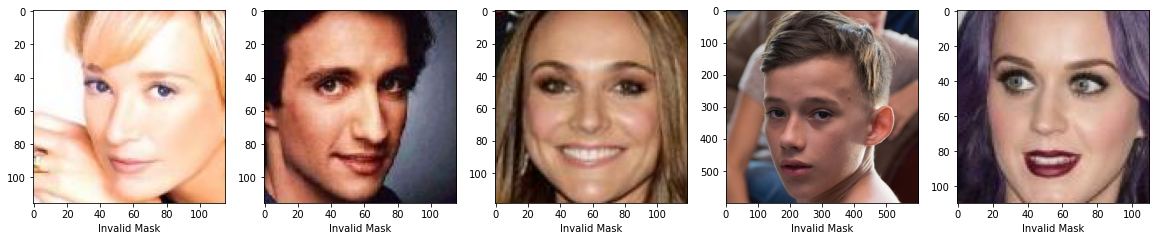

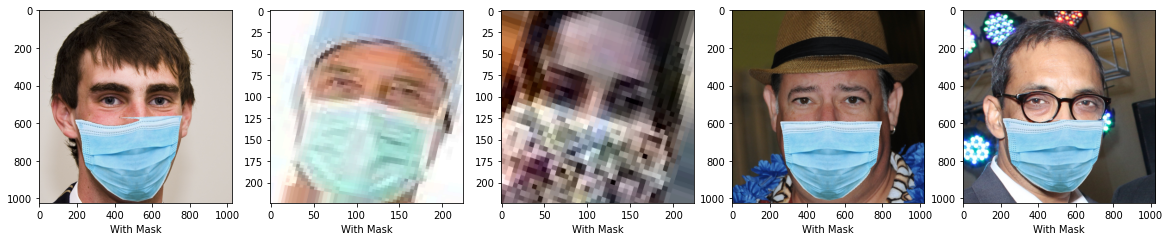

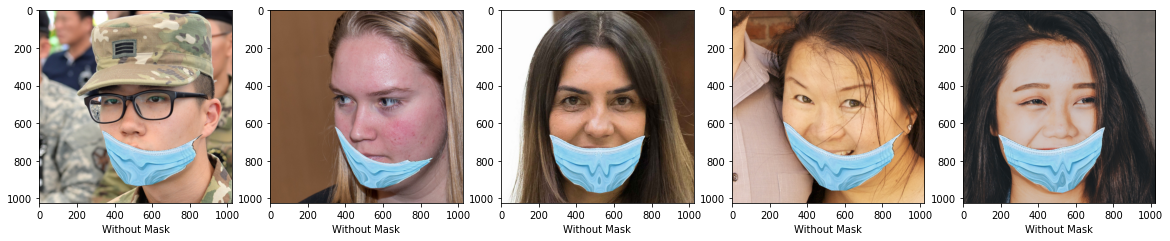

In [23]:
predict_rand_sample(5, 'Without Mask')
predict_rand_sample(5, 'With Mask')
predict_rand_sample(5, 'Invalid Mask')